In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

/Users/aayush/venvs/EE5606_venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.random.manual_seed(2778047971288475667)

In [3]:
# activation functions
def sigmoid(x):
    return 1 / (1 + torch.exp(-x))

def ReLU(x):
    return torch.max(torch.tensor(0.0), x)  # max(0, x)

def tanh(x):
    return torch.tanh(x)

def PReLU(x):
    return torch.max(0.01 * x, x)  # max(0.01 * x, x)

def softmax(x):
    return torch.exp(x) / torch.sum(torch.exp(x), dim=0)

### Q1

#### Convolution Function

In [4]:
class Convolution:
    def __init__(self, in_channels, out_channels, kernel_size, padding=(0,0), stride=(1,1), activation_function=ReLU):
        # kernel_size is a tuple of (kernel_height, kernel_width)
        # stride is a tuple of (stride_height, stride_width)
        # padding is a tuple of (padding_height, padding_width) applied to both sides of the image
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.weights = torch.randn(out_channels, in_channels, kernel_size[0], kernel_size[1])
        self.bias = torch.randn(out_channels)
        self.activation_function = activation_function

    def convolve(self, input_image):
        # input_image is torch tensor of shape (height, width, in_channels)
        # output is torch tensor of shape (height, width, out_channels) after applying convolution and activation function

        # add padding to input_image
        # concat torch.zeros of dimesion (padding[0], width, in_channels) to input_image on top and bottom
        # concat torch.zeros of dimesion (height, padding[1], in_channels) to input_image on left and right
        top_bottom_padding = torch.zeros(self.padding[0], input_image.shape[1], input_image.shape[2])
        input_image = torch.cat((top_bottom_padding, input_image, top_bottom_padding), 0)
        left_right_padding = torch.zeros(input_image.shape[0], self.padding[1], input_image.shape[2])
        input_image = torch.cat((left_right_padding, input_image, left_right_padding), 1)

        # print(f"Input size after padding: {input_image.shape}")

        output = torch.zeros((input_image.shape[0] - self.kernel_size[0] + 1, input_image.shape[1] - self.kernel_size[1] + 1, self.out_channels))
        for out_channel in range(self.out_channels):
            for i in range(0, input_image.shape[0] - self.kernel_size[0] + 1, self.stride[0]):
                for j in range(0, input_image.shape[1] - self.kernel_size[1] + 1, self.stride[1]):
                    for in_channel in range(self.in_channels):
                        output[i, j, out_channel] += torch.sum(self.weights[out_channel, in_channel] * input_image[i:i+self.kernel_size[0], j:j+self.kernel_size[1], in_channel])
                    output[i, j, out_channel] += self.bias[out_channel]
                    output[i, j, out_channel] = self.activation_function(output[i, j, out_channel])
        return output

#### Displaying input image, filter kernel, output activation map

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(100, 99, 3)
Input info:  <class 'torch.Tensor'> torch.Size([100, 99, 3])
Output info:  <class 'torch.Tensor'> torch.Size([100, 99, 1])


Text(0.5, 1.0, 'Convolved Image')

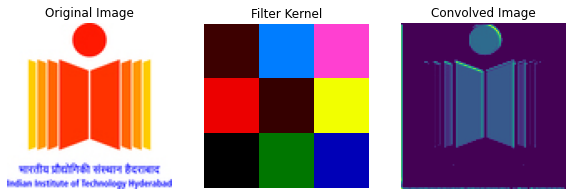

In [5]:
img = mpimg.imread('IITH_Logo_sm.jpg')
img = img[:, :, 0:3] # reduce to 3 channels from 4
print(img.shape)

figure, axis = plt.subplots(1, 3)
figure.set_figheight(10)
figure.set_figwidth(10)

# display original image 
axis[0].imshow(img)
axis[0].axis('off')
axis[0].set_title('Original Image')

img = torch.tensor(img)
print("Input info: ", type(img), img.shape)

conv_layer_instance = Convolution(3, 1, (3, 3), stride=(1, 1), padding=(1, 1), activation_function=ReLU)

# display the filter kernel
axis[1].imshow(conv_layer_instance.weights[0].permute(1, 2, 0))
axis[1].axis('off')
axis[1].set_title('Filter Kernel')

output_activations = conv_layer_instance.convolve(img)
print("Output info: ", type(output_activations), output_activations.shape)

axis[2].imshow(output_activations)
axis[2].axis('off')
axis[2].set_title('Convolved Image')

### Q2

#### Pooling Functions

In [6]:
# pooling functions
def max_pooling(input_tensor):
    # input_tensor is torch tensor of shape (kernel_height, kernel_width)
    return torch.max(input_tensor).item() # returns the maximum value in the tensor

def avg_pooling(input_tensor):
    # input_tensor is torch tensor of shape (kernel_height, kernel_width)
    return torch.mean(input_tensor).item() # returns the mean value in the tensor

#### Pool Function

In [7]:
class Pooling:
    def __init__(self, pooling_function, kernel_size=(2, 2), stride=None):
        # kernel_size is a tuple of (kernel_height, kernel_width)
        # stride is a tuple of (stride_height, stride_width)
        self.pooling_function = pooling_function
        self.kernel_size = kernel_size
        if stride is None:
            self.stride = kernel_size
        else:
            self.stride = stride


    def pool(self, output_activation):
        # output_activation is torch tensor of shape (height, width, out_channels) returned from convolve()
        # pooling_function is the pooling function to be applied
        # stride is a tuple of (stride_height, stride_width)
        # kernel_size is a tuple of (kernel_height, kernel_width) or None for global average pooling
        # pooled_output is torch tensor of shape (height/kernel_size[0], width/kernel_size[1], out_channels) after applying pooling
        
        is_global_average_pooling = False
        if self.kernel_size is None:
            # for global average pooling case
            is_global_average_pooling = True
            self.kernel_size = (output_activation.shape[0], output_activation.shape[1])
            self.stride = (output_activation.shape[0], output_activation.shape[1])
        
        pooled_output = torch.zeros(output_activation.shape[0] // self.kernel_size[0], output_activation.shape[1] // self.kernel_size[1], output_activation.shape[2])
        for out_channel in range(output_activation.shape[2]):
            for i in range(0, output_activation.shape[0], self.stride[0]):
                for j in range(0, output_activation.shape[1], self.stride[1]):

                    if i + self.kernel_size[0] > output_activation.shape[0]:
                        i = output_activation.shape[0] - self.kernel_size[0]
                    if j + self.kernel_size[1] > output_activation.shape[1]:
                        j = output_activation.shape[1] - self.kernel_size[1]
                    pooled_output[i // self.kernel_size[0], j // self.kernel_size[1], out_channel] = self.pooling_function(output_activation[i:i+self.kernel_size[0], j:j+self.kernel_size[1], out_channel])

        if is_global_average_pooling:
            self.kernel_size = None
            return pooled_output.reshape(pooled_output.shape[2], 1)
        else:
            return pooled_output

#### Displaying the output activations before and after pooling

Pooled output info:  <class 'torch.Tensor'> torch.Size([50, 49, 1])


Text(0.5, 1.0, 'Pooled Output(After Pooling)')

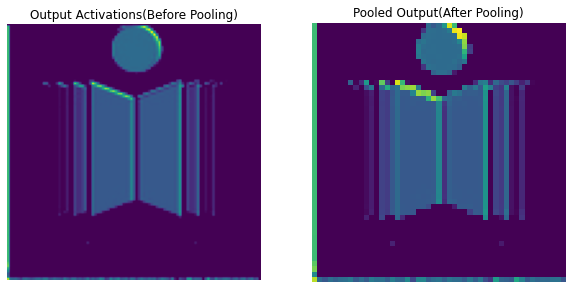

In [8]:
pooling_instance = Pooling(max_pooling, kernel_size=(2, 2)) # default stride is kernel_size

pooled_output = pooling_instance.pool(output_activations)
print("Pooled output info: ", type(pooled_output), pooled_output.shape)

figure, axis = plt.subplots(1, 2)
figure.set_figheight(10)
figure.set_figwidth(10)

# display output activations
axis[0].imshow(output_activations)
axis[0].axis('off')
axis[0].set_title('Output Activations(Before Pooling)')

# display pooled output
axis[1].imshow(pooled_output)
axis[1].axis('off')
axis[1].set_title('Pooled Output(After Pooling)')

### Q3

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Input info:  <class 'torch.Tensor'> torch.Size([100, 99, 3])
Output info:  <class 'torch.Tensor'> torch.Size([100, 99, 4])


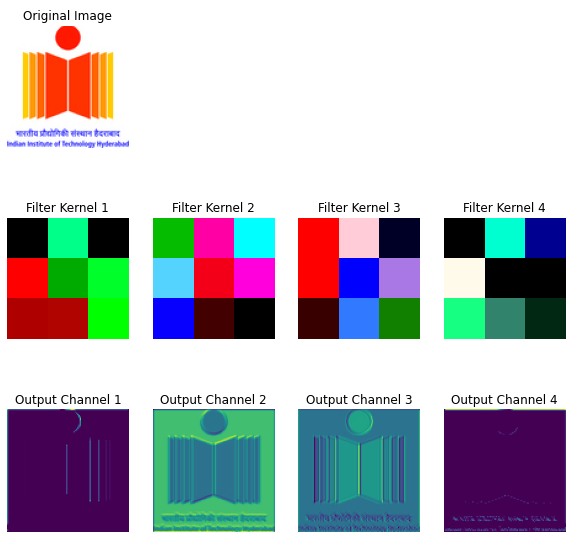

In [9]:
img = mpimg.imread('IITH_Logo_sm.jpg')
img = img[:, :, 0:3] # reduce to 3 channels from 4

figure, axis = plt.subplots(3, 4)
figure.set_figheight(10)
figure.set_figwidth(10)

# display original image
axis[0, 0].imshow(img)
axis[0, 0].axis('off')
axis[0, 0].set_title('Original Image')
axis[0, 1].axis('off')
axis[0, 2].axis('off')
axis[0, 3].axis('off')

img = torch.tensor(img)
print("Input info: ", type(img), img.shape)

n_output_channels = 4
conv_layer_multi_op_channel_instance = Convolution(3, n_output_channels, (3, 3), stride=(1, 1), padding=(1, 1), activation_function=ReLU)

# display the filter kernels
for i in range(n_output_channels):
    axis[1, i].imshow(conv_layer_multi_op_channel_instance.weights[i].permute(1, 2, 0))
    axis[1, i].axis('off')
    axis[1, i].set_title(f'Filter Kernel {i + 1}')

multi_output_activations = conv_layer_multi_op_channel_instance.convolve(img)
print("Output info: ", type(multi_output_activations), multi_output_activations.shape)

for i in range(n_output_channels):
    axis[2, i].imshow(multi_output_activations[:, :, i])
    axis[2, i].axis('off')
    axis[2, i].set_title(f'Output Channel {i + 1}')

### Q4

Pooled output info:  <class 'torch.Tensor'> torch.Size([50, 49, 4])


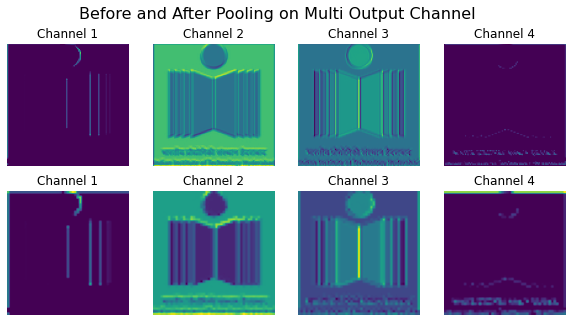

In [10]:
pooling_instance_multi_op_channel = Pooling(max_pooling, kernel_size=(2, 2))
pooled_multi_output = pooling_instance_multi_op_channel.pool(multi_output_activations) # default stride is kernel_size
print("Pooled output info: ", type(pooled_multi_output), pooled_multi_output.shape)

figure, axis = plt.subplots(2, 4)
figure.set_figheight(5)
figure.set_figwidth(10)

figure.suptitle('Before and After Pooling on Multi Output Channel', fontsize=16)

# display output activations
for i in range(n_output_channels):
    axis[0, i].imshow(multi_output_activations[:, :, i])
    axis[0, i].axis('off')
    axis[0, i].set_title(f'Channel {i + 1}')

# display pooled output
for i in range(n_output_channels):
    axis[1, i].imshow(pooled_multi_output[:, :, i])
    axis[1, i].axis('off')
    axis[1, i].set_title(f'Channel {i + 1}')

#### Global Average Pooling

In [11]:
pooling_instance_multi_op_channel_global_average = Pooling(avg_pooling, kernel_size=None)
pooled_multi_output_global_average = pooling_instance_multi_op_channel_global_average.pool(multi_output_activations)
print("Pooled output info: ", type(pooled_multi_output_global_average), pooled_multi_output_global_average.shape)

Pooled output info:  <class 'torch.Tensor'> torch.Size([4, 1])


### Q5

In [12]:
class Flatten():
    def __init__(self, input_size, output_size):
        # input_size = (height, width, channels)
        self.input_size = input_size[0] * input_size[1] * input_size[2]
        self.output_size = output_size
        self.weights = torch.randn(output_size, self.input_size)

    def flatten(self, input_tensor):
        # input_tensor is torch tensor of shape (height, width, channels)
        # output is torch tensor of shape output_size
        return self.weights @ input_tensor.reshape(self.input_size, 1)

### Q6

In [13]:
class MultiLayerPerceptron:
    def __init__(self, layer_sizes, activation_function):
        self.layer_sizes = layer_sizes
        self.activation_function = activation_function
        self.num_layers = len(layer_sizes)
        self.biases = [torch.randn(layer_size, 1) for layer_size in layer_sizes[1:]]
        self.weights = [torch.randn(layer_size, layer_sizes[index-1]) for index, layer_size in enumerate(layer_sizes) if index != 0]

    def forward_propagation(self, input_tensor):
        # input_tensor is flattened input of shape (input_size, 1)
        # activations of size: num_layers + 1
        # zs of size: num_layers
        # softmax_output of size: (output_size, 1), applies softmax on activations[-1]
        activations = [input_tensor]
        zs =[]
        for index, layer_size in enumerate(self.layer_sizes):
            if index == len(self.layer_sizes) - 1:
                break
            z = self.weights[index] @ activations[-1] + self.biases[index]
            zs.append(z)
            activations.append(self.activation_function(z))
        
        softmax_output = softmax(activations[-1])

        return (zs, activations, softmax_output)

### Q7

#### Load the CIFAR 10 dataset

In [14]:
transform = transforms.Compose(
    [transforms.ToTensor()])
    #  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
# trainset[i][0] is a tensor of shape (3, 32, 32) and contains the image
# trainset[i][1] is a tensor of shape (1,) and contains the label

Files already downloaded and verified


#### Displaying first 10 images from CIFAR-10 dataset along with their labels

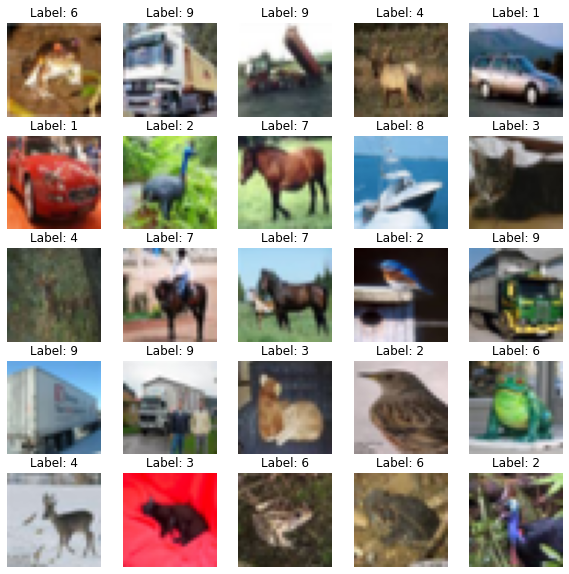

In [15]:
figure, axis = plt.subplots(5, 5)
figure.set_figheight(10)
figure.set_figwidth(10)

for i in range(5):
    for j in range(5):
        axis[i, j].imshow(trainset[i*5 + j][0].permute(1, 2, 0))
        axis[i, j].axis('off')
        axis[i, j].set_title(f'Label: {trainset[i*5 + j][1]}')

#### CNN Pipeline

In [16]:
cnn_pipleline = [
    Convolution(3, 16, (3, 3), activation_function=sigmoid),
    Pooling(max_pooling, kernel_size=(2, 2), stride=(2, 2)),
    Convolution(16, 8, (3, 3), activation_function=sigmoid),
    Pooling(max_pooling, kernel_size=(2, 2), stride=(2, 2)),
    Pooling(avg_pooling, kernel_size=None), # Global Average Pooling
    MultiLayerPerceptron([8, 8, 10], activation_function=sigmoid)
]

In [17]:
def forward_propagation_cnn(input_tensor, verbose=False):
    # input_tensor is a tensor of shape (32, 32, 3)
    for instance in cnn_pipleline:
        layer_type = instance.__class__.__name__
        if verbose:
            print(input_tensor.shape, layer_type)
        if layer_type == 'Convolution':
            input_tensor = instance.convolve(input_tensor)
        elif layer_type == 'Pooling':
            input_tensor = instance.pool(input_tensor)
        elif layer_type == 'MultiLayerPerceptron': # last layer
            input_tensor = instance.forward_propagation(input_tensor)
            output = input_tensor
            # output is a tuple of (zs, activations, softmax_output)
            # output[0] is a list of z tensors of size (layer_size, 1)
            # output[1] is a list of activation tensors of size (layer_size + 1, 1)
            # output[2] is a tensor of size (output_size, 1) and contains softmax output
            output_list = output[2].reshape(10).tolist()
            if verbose:
                print("====================================")
                for index, value in enumerate(output_list):
                    print(f'Output(After softmax) for label {index + 1}: {value}')
            return output_list

In [18]:
# running the pipeline over trainset[0][0]
_ = forward_propagation_cnn(trainset[0][0].permute(1, 2, 0), verbose=True)

torch.Size([32, 32, 3]) Convolution
torch.Size([30, 30, 16]) Pooling
torch.Size([15, 15, 16]) Convolution
torch.Size([13, 13, 8]) Pooling
torch.Size([6, 6, 8]) Pooling
torch.Size([8, 1]) MultiLayerPerceptron
Output(After softmax) for label 1: 0.10894346237182617
Output(After softmax) for label 2: 0.14169469475746155
Output(After softmax) for label 3: 0.07719939202070236
Output(After softmax) for label 4: 0.13347691297531128
Output(After softmax) for label 5: 0.08277928084135056
Output(After softmax) for label 6: 0.12826715409755707
Output(After softmax) for label 7: 0.059275105595588684
Output(After softmax) for label 8: 0.07974282652139664
Output(After softmax) for label 9: 0.12816110253334045
Output(After softmax) for label 10: 0.0604601725935936


### Q8a

#### Get 30 images, 3 from each of the 10 classes

In [19]:
images = {}
for i in range(10):
    images[i] = []
count = 0
for i in range(len(trainset)):
    if count == 30:
        # print(i) # 70
        break
    label = trainset[i][1]
    if len(images[label]) == 3:
        continue
    images[label].append(trainset[i][0])
    count += 1

#### Display the images

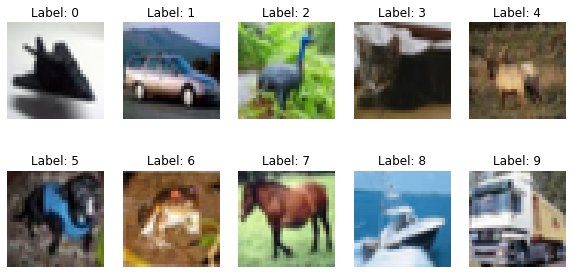

In [20]:
figure, axis = plt.subplots(2, 5)
figure.set_figheight(5)
figure.set_figwidth(10)

for i in range(2):
    for j in range(5):
        axis[i, j].imshow(images[i*5 + j][0].permute(1, 2, 0))
        axis[i, j].axis('off')
        axis[i, j].set_title(f'Label: {i*5 + j}')

#### Getting output for the 10 images, one for each class

In [21]:
outputs = []
for i in range(10):
    image = images[i][0]
    _ = forward_propagation_cnn(image.permute(1, 2, 0))
    outputs.append(torch.tensor(_))

#### Getting the maximum euclidean distance among these 10 10X1 tensors

In [22]:
max_distance = 0
for i in range(10):
    for j in range(i+1, 10):
        distance = torch.dist(outputs[i], outputs[j])
        if distance > max_distance:
            max_distance = distance

print(f'Max distance between among the softmax output {max_distance}')

Max distance between among the softmax output 0.007767767179757357


#### Trend in output

It can be seen that for all these 10 images belonging to the 10 classes, the 10 X 1 output vector for each of the input image is almost same for all. The maximum Euclidean distance among these 10 10 X 1 vectors is also computed as the output of the previous cell. It came out to be 0.005 on an average in my runs meaning the vectors are "close by" in 10-D space.

### Q8b

#### Run the pipeline on the 30 images(10 from each class)

In [23]:
outputs = torch.randn(30, 10)
for i in range(10):
    for j in range(3):
        image = images[i][j]
        _ = forward_propagation_cnn(image.permute(1, 2, 0))
        outputs[i*3 + j] = torch.tensor(_)
# outputs is a tensor of size (30, 10) and contains softmax output for all images

#### Applying PCA on all the 30 vectors and reducing their dimensionality to 2

In [24]:
U, _, _ = torch.pca_lowrank(outputs, q=2, center=True, niter=20)
print(U.shape) # (30, 2)

torch.Size([30, 2])


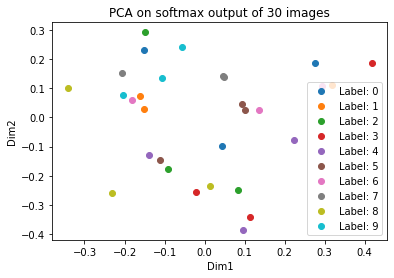

In [25]:
for i in range(0, 30, 3):
    plt.scatter(U[i:i+3, 0], U[i:i+3, 1], label=f'Label: {i//3}')
plt.legend()
plt.xlabel('Dim1')
plt.ylabel('Dim2')
plt.title('PCA on softmax output of 30 images')
plt.show()

#### Explanation

As seen from the max distance(calculated in Q8a) and visualized from the plot above, we can say that a random initialized CNN DOES NOT discriminate between any image input it has been given. All the 30 points, after reduing their dimensions from 10 to 2 fit nicely in a square of size 0.7 * 0.7.

In [26]:
print(torch.seed())

9844676880161781651
